### 制作特征和标签， 转成监督学习问题
我们先捋一下基于原始的给定数据， 有哪些特征可以直接利用：

- 文章的自身特征， category_id表示这文章的类型， created_at_ts表示文章建立的时间， 这个关系着文章的时效性， words_count是文章的字数， 一般字数太长我们不太喜欢点击, 也不排除有人就喜欢读长文。

- 文章的内容embedding特征， 这个召回的时候用过， 这里可以选择使用， 也可以选择不用， 也可以尝试其他类型的embedding特征， 比如W2V等
用户的设备特征信息

- 上面这些直接可以用的特征， 待做完特征工程之后， 直接就可以根据article_id或者是user_id把这些特征加入进去。 但是我们需要先基于召回的结果， 构造一些特征，然后制作标签，形成一个监督学习的数据集。

构造监督数据集的思路， 根据召回结果， 我们会得到一个{user_id: [可能点击的文章列表]}形式的字典。 那么我们就可以对于每个用户， 每篇可能点击的文章构造一个监督测试集， 比如对于用户user1， 假设得到的他的召回列表{user1: [item1, item2, item3]}， 我们就可以得到三行数据(user1, item1), (user1, item2), (user1, item3)的形式， 这就是监督测试集时候的前两列特征。


构造特征的思路是这样， 我们知道每个用户的点击文章是与其历史点击的文章信息是有很大关联的， 比如同一个主题， 相似等等。 所以特征构造这块很重要的一系列特征是要结合用户的历史点击文章信息。我们已经得到了每个用户及点击候选文章的两列的一个数据集， 而我们的目的是要预测最后一次点击的文章， 比较自然的一个思路就是和其最后几次点击的文章产生关系， 这样既考虑了其历史点击文章信息， 又得离最后一次点击较近，因为新闻很大的一个特点就是注重时效性。 往往用户的最后一次点击会和其最后几次点击有很大的关联。 所以我们就可以对于每个候选文章， 做出与最后几次点击相关的特征如下：

- 候选item与最后几次点击的相似性特征(embedding内积） --- 这个直接关联用户历史行为
- 候选item与最后几次点击的相似性特征的统计特征 --- 统计特征可以减少一些波动和异常
- 候选item与最后几次点击文章的字数差的特征 --- 可以通过字数看用户偏好
- 候选item与最后几次点击的文章建立的时间差特征 --- 时间差特征可以看出该用户对于文章的实时性的偏好
还需要考虑一下 5. 如果使用了youtube召回的话， 我们还可以制作用户与候选item的相似特征

当然， 上面只是提供了一种基于用户历史行为做特征工程的思路， 大家也可以思维风暴一下，尝试一些其他的特征。 下面我们就实现上面的这些特征的制作， 下面的逻辑是这样：

- 我们首先获得用户的最后一次点击操作和用户的历史点击， 这个基于我们的日志数据集做

- 基于用户的历史行为制作特征， 这个会用到用户的历史点击表， 最后的召回列表， 文章的信息表和embedding向量

- 制作标签， 形成最后的监督学习数据集

In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import gc, os
import logging
import time
import lightgbm as lgb
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 节省内存的一个函数
# 减少内存
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,
                                                                                                           100*(start_mem-end_mem)/start_mem,
                                                                                                           (time.time()-starttime)/60))
    return df

In [3]:
data_path = '../data-compte/'
save_path = '../temp_results/'

### 数据读取
#### 训练和验证集的划分
划分训练和验证集的原因是为了在线下验证模型参数的好坏，为了完全模拟测试集，我们这里就在训练集中抽取部分用户的所有信息来作为验证集。提前做训练验证集划分的好处就是可以分解制作排序特征时的压力，一次性做整个数据集的排序特征可能时间会比较长。

In [4]:
# all_click_df指的是训练集
# sample_user_nums 采样作为验证集的用户数量
def trn_val_split(all_click_df, sample_user_nums):
    all_click = all_click_df
    all_user_ids = all_click.user_id.unique()
    
    # replace=True表示可以重复抽样，反之不可以
    sample_user_ids = np.random.choice(all_user_ids, size=sample_user_nums, replace=False) 
    
    click_val = all_click[all_click['user_id'].isin(sample_user_ids)]
    click_trn = all_click[~all_click['user_id'].isin(sample_user_ids)]
    
    # 将验证集中的最后一次点击给抽取出来作为答案
    click_val = click_val.sort_values(['user_id', 'click_timestamp'])
    val_ans = click_val.groupby('user_id').tail(1)
    
    click_val = click_val.groupby('user_id').apply(lambda x: x[:-1]).reset_index(drop=True)
    
    # 去除val_ans中某些用户只有一个点击数据的情况，如果该用户只有一个点击数据，又被分到ans中，
    # 那么训练集中就没有这个用户的点击数据，出现用户冷启动问题，给自己模型验证带来麻烦
    val_ans = val_ans[val_ans.user_id.isin(click_val.user_id.unique())] # 保证答案中出现的用户再验证集中还有
    click_val = click_val[click_val.user_id.isin(val_ans.user_id.unique())]
    
    return click_trn, click_val, val_ans

### 获取历史点击和最后一次点击

In [5]:
# 获取当前数据的历史点击和最后一次点击
def get_hist_and_last_click(all_click):
    all_click = all_click.sort_values(by=['user_id', 'click_timestamp'])
    click_last_df = all_click.groupby('user_id').tail(1)

    # 如果用户只有一个点击，hist为空了，会导致训练的时候这个用户不可见，此时默认泄露一下
    def hist_func(user_df):
        if len(user_df) == 1:
            return user_df
        else:
            return user_df[:-1]

    click_hist_df = all_click.groupby('user_id').apply(hist_func).reset_index(drop=True)

    return click_hist_df, click_last_df

### 读取训练、验证及测试集

In [6]:
def get_trn_val_tst_data(data_path, offline=True):
    if offline:
        click_trn_data = pd.read_csv(data_path+'train_click_log.csv')  # 训练集用户点击日志
        click_trn_data = reduce_mem(click_trn_data)
        click_trn, click_val, val_ans = trn_val_split(all_click_df, sample_user_nums)
    else:
        click_trn = pd.read_csv(data_path+'train_click_log.csv')
        click_trn = reduce_mem(click_trn)
        click_val = None
        val_ans = None
    
    click_tst = pd.read_csv(data_path+'testA_click_log.csv')
    
    return click_trn, click_val, click_tst, val_ans

### 读取召回列表

In [7]:
# 返回多路召回列表或者单路召回
def get_recall_list(save_path, single_recall_model=None, multi_recall=False):
    if multi_recall:
        return pickle.load(open(save_path + 'final_recall_items_dict.pkl', 'rb'))
    
    if single_recall_model == 'i2i_itemcf':
        return pickle.load(open(save_path + 'itemcf_recall_dict.pkl', 'rb'))
    elif single_recall_model == 'i2i_emb_itemcf':
        return pickle.load(open(save_path + 'itemcf_emb_dict.pkl', 'rb'))
    elif single_recall_model == 'user_cf':
        return pickle.load(open(save_path + 'youtubednn_usercf_dict.pkl', 'rb'))
    elif single_recall_model == 'youtubednn':
        return pickle.load(open(save_path + 'youtube_u2i_dict.pkl', 'rb'))

### 读取各种Embedding

#### Word2Vec训练及gensim的使用

Word2Vec主要思想是：一个词的上下文可以很好的表达出词的语义。通过无监督学习产生词向量的方式。word2vec中有两个非常经典的模型：skip-gram和cbow。

skip-gram：已知中心词预测周围词。

cbow：已知周围词预测中心词。
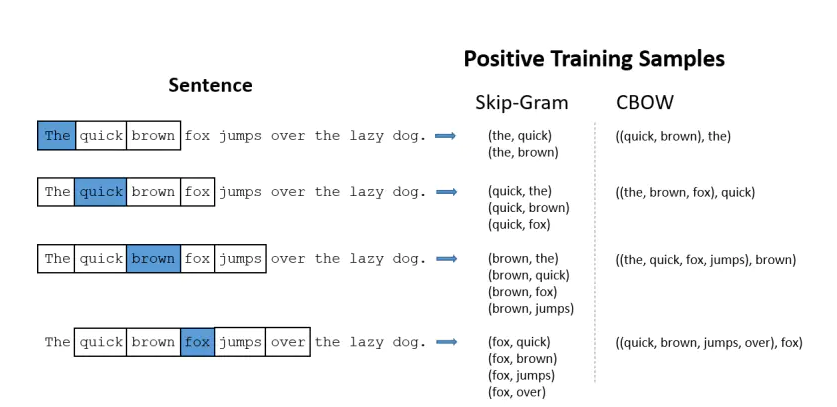

在使用gensim训练word2vec的时候，有几个比较重要的参数

- size: 表示词向量的维度。
- window：决定了目标词会与多远距离的上下文产生关系。
- sg: 如果是0，则是CBOW模型，是1则是Skip-Gram模型。
- workers: 表示训练时候的线程数量
- min_count: 设置最小的
- iter: 训练时遍历整个数据集的次数

注意

- 训练的时候输入的语料库一定要是字符组成的二维数组，如：[['北', '京', '你', '好'], ['上', '海', '你', '好']]
- 使用模型的时候有一些默认值，可以通过在Jupyter里面通过Word2Vec??查看
下面是个简单的测试样例：

 from gensim.models import Word2Vec
 doc = [['30760', '157507'],
       ['289197', '63746'],
       ['36162', '168401'],
       ['50644', '36162']]
 w2v = Word2Vec(docs, size=12, sg=1, window=2, seed=2020, workers=2, min_count=1, iter=1)

# 查看'30760'表示的词向量
w2v['30760']
skip-gram和cbow的详细原理可以参考下面的博客：

- word2vec原理(一) CBOW与Skip-Gram模型基础
- word2vec原理(二) 基于Hierarchical Softmax的模型
- word2vec原理(三) 基于Negative Sampling的模型

In [8]:
def trian_item_word2vec(click_df, embed_size=64, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values('click_timestamp')
    # 只有转换成字符串才可以进行训练
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)
    # 转换成句子的形式
    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    # 为了方便查看训练的进度，这里设定一个log信息
    logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

    # 这里的参数对训练得到的向量影响也很大,默认负采样为5
    w2v = Word2Vec(docs, size=16, sg=1, window=5, seed=2020, workers=24, min_count=1, iter=1)
    
    # 保存成字典的形式
    item_w2v_emb_dict = {k: w2v[k] for k in click_df['click_article_id']}
    pickle.dump(item_w2v_emb_dict, open(save_path + 'item_w2v_emb.pkl', 'wb'))
    
    return item_w2v_emb_dict

In [9]:
# 可以通过字典查询对应的item的Embedding
def get_embedding(save_path, all_click_df):
    if os.path.exists(save_path + 'item_content_emb.pkl'):
        item_content_emb_dict = pickle.load(open(save_path + 'item_content_emb.pkl', 'rb'))
    else:
        print('item_content_emb.pkl 文件不存在...')
        
    # w2v Embedding是需要提前训练好的
    if os.path.exists(save_path + 'item_w2v_emb.pkl'):
        item_w2v_emb_dict = pickle.load(open(save_path + 'item_w2v_emb.pkl', 'rb'))
    else:
        item_w2v_emb_dict = trian_item_word2vec(all_click_df)
        
    if os.path.exists(save_path + 'item_youtube_emb.pkl'):
        item_youtube_emb_dict = pickle.load(open(save_path + 'item_youtube_emb.pkl', 'rb'))
    else:
        print('item_youtube_emb.pkl 文件不存在...')
    
    if os.path.exists(save_path + 'user_youtube_emb.pkl'):
        user_youtube_emb_dict = pickle.load(open(save_path + 'user_youtube_emb.pkl', 'rb'))
    else:
        print('user_youtube_emb.pkl 文件不存在...')
    
    return item_content_emb_dict, item_w2v_emb_dict, item_youtube_emb_dict, user_youtube_emb_dict

### 读取文章信息

In [10]:
def get_article_info_df():
    article_info_df = pd.read_csv(data_path + 'articles.csv')
    article_info_df = reduce_mem(article_info_df)
    
    return article_info_df

### 读取数据

In [ ]:
# 这里offline的online的区别就是验证集是否为空
click_trn, click_val, click_tst, val_ans = get_trn_val_tst_data(data_path, offline=False)

In [ ]:
click_trn_hist, click_trn_last = get_hist_and_last_click(click_trn)

if click_val is not None:
    click_val_hist, click_val_last = click_val, val_ans
else:
    click_val_hist, click_val_last = None, None
    
click_tst_hist = click_tst

### 对训练数据做负采样

通过召回我们将数据转换成三元组的形式（user1, item1, label）的形式，观察发现正负样本差距极度不平衡，我们可以先对负样本进行下采样，下采样的目的一方面缓解了正负样本比例的问题，另一方面也减小了我们做排序特征的压力，我们在做负采样的时候又有哪些东西是需要注意的呢？

- 只对负样本进行下采样(如果有比较好的正样本扩充的方法其实也是可以考虑的)
- 负采样之后，保证所有的用户和文章仍然出现在采样之后的数据中
- 下采样的比例可以根据实际情况人为的控制
- 做完负采样之后，更新此时新的用户召回文章列表，因为后续做特征的时候可能用到相对位置的信息。
其实负采样也可以留在后面做完特征在进行，这里由于做排序特征太慢了，所以把负采样的环节提到前面了。

In [ ]:
# 将召回列表转换成df的形式
def recall_dict_2_df(recall_list_dict):
    df_row_list = [] # [user, item, score]
    for user, recall_list in tqdm(recall_list_dict.items()):
        for item, score in recall_list:
            df_row_list.append([user, item, score])
    
    col_names = ['user_id', 'sim_item', 'score']
    recall_list_df = pd.DataFrame(df_row_list, columns=col_names)
    
    return recall_list_df

In [ ]:
# 负采样函数，这里可以控制负采样时的比例, 这里给了一个默认的值
def neg_sample_recall_data(recall_items_df, sample_rate=0.001):
    pos_data = recall_items_df[recall_items_df['label'] == 1]
    neg_data = recall_items_df[recall_items_df['label'] == 0]
    
    print('pos_data_num:', len(pos_data), 'neg_data_num:', len(neg_data), 'pos/neg:', len(pos_data)/len(neg_data))
    
    # 分组采样函数
    def neg_sample_func(group_df):
        neg_num = len(group_df)
        sample_num = max(int(neg_num * sample_rate), 1) # 保证最少有一个
        sample_num = min(sample_num, 5) # 保证最多不超过5个，这里可以根据实际情况进行选择
        return group_df.sample(n=sample_num, replace=True)
    
    # 对用户进行负采样，保证所有用户都在采样后的数据中
    neg_data_user_sample = neg_data.groupby('user_id', group_keys=False).apply(neg_sample_func)
    # 对文章进行负采样，保证所有文章都在采样后的数据中
    neg_data_item_sample = neg_data.groupby('sim_item', group_keys=False).apply(neg_sample_func)
    
    # 将上述两种情况下的采样数据合并
    neg_data_new = neg_data_user_sample.append(neg_data_item_sample)
    # 由于上述两个操作是分开的，可能将两个相同的数据给重复选择了，所以需要对合并后的数据进行去重
    neg_data_new = neg_data_new.sort_values(['user_id', 'score']).drop_duplicates(['user_id', 'sim_item'], keep='last')
    
    # 将正样本数据合并
    data_new = pd.concat([pos_data, neg_data_new], ignore_index=True)
    
    return data_new

In [ ]:
# 召回数据打标签
def get_rank_label_df(recall_list_df, label_df, is_test=False):
    # 测试集是没有标签了，为了后面代码同一一些，这里直接给一个负数替代
    if is_test:
        recall_list_df['label'] = -1
        return recall_list_df
    
    label_df = label_df.rename(columns={'click_article_id': 'sim_item'})
    recall_list_df_ = recall_list_df.merge(label_df[['user_id', 'sim_item', 'click_timestamp']], \
                                               how='left', on=['user_id', 'sim_item'])
    recall_list_df_['label'] = recall_list_df_['click_timestamp'].apply(lambda x: 0.0 if np.isnan(x) else 1.0)
    del recall_list_df_['click_timestamp']
    
    return recall_list_df_

In [ ]:
def get_user_recall_item_label_df(click_trn_hist, click_val_hist, click_tst_hist,click_trn_last, click_val_last, recall_list_df):
    # 获取训练数据的召回列表
    trn_user_items_df = recall_list_df[recall_list_df['user_id'].isin(click_trn_hist['user_id'].unique())]
    # 训练数据打标签
    trn_user_item_label_df = get_rank_label_df(trn_user_items_df, click_trn_last, is_test=False)
    # 训练数据负采样
    trn_user_item_label_df = neg_sample_recall_data(trn_user_item_label_df)
    
    if click_val is not None:
        val_user_items_df = recall_list_df[recall_list_df['user_id'].isin(click_val_hist['user_id'].unique())]
        val_user_item_label_df = get_rank_label_df(val_user_items_df, click_val_last, is_test=False)
        val_user_item_label_df = neg_sample_recall_data(val_user_item_label_df)
    else:
        val_user_item_label_df = None
        
    # 测试数据不需要进行负采样，直接对所有的召回商品进行打-1标签
    tst_user_items_df = recall_list_df[recall_list_df['user_id'].isin(click_tst_hist['user_id'].unique())]
    tst_user_item_label_df = get_rank_label_df(tst_user_items_df, None, is_test=True)
    
    return trn_user_item_label_df, val_user_item_label_df, tst_user_item_label_df

In [ ]:
# 读取召回列表
recall_list_dict = get_recall_list(save_path, single_recall_model='i2i_itemcf') # 这里只选择了单路召回的结果，也可以选择多路召回结果
# 将召回数据转换成df
recall_list_df = recall_dict_2_df(recall_list_dict)

In [ ]:
# 给训练验证数据打标签，并负采样（这一部分时间比较久）
trn_user_item_label_df, val_user_item_label_df, tst_user_item_label_df = get_user_recall_item_label_df(click_trn_hist, 
                                                                                                       click_val_hist, 
                                                                                                       click_tst_hist,
                                                                                                       click_trn_last, 
                                                                                                       click_val_last, 
                                                                                                       recall_list_df)

In [ ]:
trn_user_item_label_df.label

### 将召回数据转换成字典

In [ ]:
# 将最终的召回的df数据转换成字典的形式做排序特征
def make_tuple_func(group_df):
    row_data = []
    for name, row_df in group_df.iterrows():
        row_data.append((row_df['sim_item'], row_df['score'], row_df['label']))
    
    return row_data

In [ ]:
trn_user_item_label_tuples = trn_user_item_label_df.groupby('user_id').apply(make_tuple_func).reset_index()
trn_user_item_label_tuples_dict = dict(zip(trn_user_item_label_tuples['user_id'], trn_user_item_label_tuples[0]))

if val_user_item_label_df is not None:
    val_user_item_label_tuples = val_user_item_label_df.groupby('user_id').apply(make_tuple_func).reset_index()
    val_user_item_label_tuples_dict = dict(zip(val_user_item_label_tuples['user_id'], val_user_item_label_tuples[0]))
else:
    val_user_item_label_tuples_dict = None
    
tst_user_item_label_tuples = tst_user_item_label_df.groupby('user_id').apply(make_tuple_func).reset_index()
tst_user_item_label_tuples_dict = dict(zip(tst_user_item_label_tuples['user_id'], tst_user_item_label_tuples[0]))

### 特征工程
#### 制作与用户历史行为相关特征
对于每个用户召回的每个商品， 做特征。 具体步骤如下：

- 对于每个用户， 获取最后点击的N个商品的item_id，
- - 对于该用户的每个召回商品， 计算与上面最后N次点击商品的相似度的和(最大， 最小，均值)， 时间差特征，相似性特征，字数差特征，与该用户的相似性特征

In [11]:
# 下面基于data做历史相关的特征
def create_feature(users_id, recall_list, click_hist_df,  articles_info, articles_emb, user_emb=None, N=1):
    """
    基于用户的历史行为做相关特征
    :param users_id: 用户id
    :param recall_list: 对于每个用户召回的候选文章列表
    :param click_hist_df: 用户的历史点击信息
    :param articles_info: 文章信息
    :param articles_emb: 文章的embedding向量, 这个可以用item_content_emb, item_w2v_emb, item_youtube_emb
    :param user_emb: 用户的embedding向量， 这个是user_youtube_emb, 如果没有也可以不用， 但要注意如果要用的话， articles_emb就要用item_youtube_emb的形式， 这样维度才一样
    :param N: 最近的N次点击  由于testA日志里面很多用户只存在一次历史点击， 所以为了不产生空值，默认是1
    """
    
    # 建立一个二维列表保存结果， 后面要转成DataFrame
    all_user_feas = []
    i = 0
    for user_id in tqdm(users_id):
        # 该用户的最后N次点击
        hist_user_items = click_hist_df[click_hist_df['user_id']==user_id]['click_article_id'][-N:]
        
        # 遍历该用户的召回列表
        for rank, (article_id, score, label) in enumerate(recall_list[user_id]):
            # 该文章建立时间, 字数
            a_create_time = articles_info[articles_info['article_id']==article_id]['created_at_ts'].values[0]
            a_words_count = articles_info[articles_info['article_id']==article_id]['words_count'].values[0]
            single_user_fea = [user_id, article_id]
            # 计算与最后点击的商品的相似度的和， 最大值和最小值， 均值
            sim_fea = []
            time_fea = []
            word_fea = []
            # 遍历用户的最后N次点击文章
            for hist_item in hist_user_items:
                b_create_time = articles_info[articles_info['article_id']==hist_item]['created_at_ts'].values[0]
                b_words_count = articles_info[articles_info['article_id']==hist_item]['words_count'].values[0]
                
                sim_fea.append(np.dot(articles_emb[hist_item], articles_emb[article_id]))
                time_fea.append(abs(a_create_time-b_create_time))
                word_fea.append(abs(a_words_count-b_words_count))
                
            single_user_fea.extend(sim_fea)      # 相似性特征
            single_user_fea.extend(time_fea)    # 时间差特征
            single_user_fea.extend(word_fea)    # 字数差特征
            single_user_fea.extend([max(sim_fea), min(sim_fea), sum(sim_fea), sum(sim_fea) / len(sim_fea)])  # 相似性的统计特征
            
            if user_emb:  # 如果用户向量有的话， 这里计算该召回文章与用户的相似性特征 
                single_user_fea.append(np.dot(user_emb[user_id], articles_emb[article_id]))
                
            single_user_fea.extend([score, rank, label])    
            # 加入到总的表中
            all_user_feas.append(single_user_fea)
    
    # 定义列名
    id_cols = ['user_id', 'click_article_id']
    sim_cols = ['sim' + str(i) for i in range(N)]
    time_cols = ['time_diff' + str(i) for i in range(N)]
    word_cols = ['word_diff' + str(i) for i in range(N)]
    sat_cols = ['sim_max', 'sim_min', 'sim_sum', 'sim_mean']
    user_item_sim_cols = ['user_item_sim'] if user_emb else []
    user_score_rank_label = ['score', 'rank', 'label']
    cols = id_cols + sim_cols + time_cols + word_cols + sat_cols + user_item_sim_cols + user_score_rank_label
            
    # 转成DataFrame
    df = pd.DataFrame( all_user_feas, columns=cols)
    
    return df

In [ ]:
article_info_df = get_article_info_df()
all_click = click_trn.append(click_tst)
item_content_emb_dict, item_w2v_emb_dict, item_youtube_emb_dict, user_youtube_emb_dict = get_embedding(save_path, all_click)

In [ ]:
# 获取训练验证及测试数据中召回列文章相关特征
trn_user_item_feats_df = create_feature(trn_user_item_label_tuples_dict.keys(), trn_user_item_label_tuples_dict, \
                                            click_trn_hist, article_info_df, item_content_emb_dict)

if val_user_item_label_tuples_dict is not None:
    val_user_item_feats_df = create_feature(val_user_item_label_tuples_dict.keys(), val_user_item_label_tuples_dict, \
                                                click_val_hist, article_info_df, item_content_emb_dict)
else:
    val_user_item_feats_df = None
    
tst_user_item_feats_df = create_feature(tst_user_item_label_tuples_dict.keys(), tst_user_item_label_tuples_dict, \
                                            click_tst_hist, article_info_df, item_content_emb_dict)


In [ ]:
# 保存一份省的每次都要重新跑，每次跑的时间都比较长
trn_user_item_feats_df.to_csv(save_path + 'trn_user_item_feats_df.csv', index=False)

if val_user_item_feats_df is not None:
    val_user_item_feats_df.to_csv(save_path + 'val_user_item_feats_df.csv', index=False)

tst_user_item_feats_df.to_csv(save_path + 'tst_user_item_feats_df.csv', index=False)

### 用户和文章特征
#### 用户相关特征

这一块，正式进行特征工程，既要拼接上已有的特征， 也会做更多的特征出来，我们来梳理一下已有的特征和可构造特征：

- 文章自身的特征， 文章字数，文章创建时间， 文章的embedding （articles表中)
- 用户点击环境特征， 那些设备的特征(这个在df中)
- 对于用户和商品还可以构造的特征：
- - 基于用户的点击文章次数和点击时间构造可以表现用户活跃度的特征
- - 基于文章被点击次数和时间构造可以反映文章热度的特征
- - 用户的时间统计特征： 根据其点击的历史文章列表的点击时间和文章的创建时间做统计特征，比如求均值， 这个可以反映用户对于文章时效的偏好
- - 用户的主题爱好特征， 对于用户点击的历史文章主题进行一个统计， 然后对于当前文章看看是否属于用户已经点击过的主题
- - 用户的字数爱好特征， 对于用户点击的历史文章的字数统计， 求一个均值

In [ ]:
click_tst.head()

In [ ]:
# 读取文章特征
articles =  pd.read_csv(data_path+'articles.csv')
articles = reduce_mem(articles)

# 日志数据，就是前面的所有数据
if click_val is not None:
    all_data = click_trn.append(click_val)
all_data = click_trn.append(click_tst)
all_data = reduce_mem(all_data)

# 拼上文章信息
all_data = all_data.merge(articles, left_on='click_article_id', right_on='article_id')

In [ ]:
all_data.shape

#### 分析一下点击时间和点击文章的次数，区分用户活跃度

如果某个用户点击文章之间的时间间隔比较小， 同时点击的文章次数很多的话， 那么我们认为这种用户一般就是活跃用户, 当然衡量用户活跃度的方式可能多种多样， 这里我们只提供其中一种，我们写一个函数， 得到可以衡量用户活跃度的特征，逻辑如下：

- 首先根据用户user_id分组， 对于每个用户，计算点击文章的次数， 两两点击文章时间间隔的均值
- 把点击次数取倒数和时间间隔的均值统一归一化，然后两者相加合并，该值越小， 说明用户越活跃
- 注意， 上面两两点击文章的时间间隔均值， 会出现如果用户只点击了一次的情况，这时候时间间隔均值那里会出现空值， 对于这种情况最后特征那里给个大数进行区分
这个的衡量标准就是先把点击的次数取到数然后归一化， 然后点击的时间差归一化， 然后两者相加进行合并， 该值越小， 说明被点击的次数越多， 且间隔时间短。

In [12]:
def active_level(all_data, cols):
    """
    制作区分用户活跃度的特征
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    data = all_data[cols]
    data.sort_values(['user_id', 'click_timestamp'], inplace=True)
    user_act = pd.DataFrame(data.groupby('user_id', as_index=False)[['click_article_id', 'click_timestamp']].\
                            agg({'click_article_id':np.size, 'click_timestamp': {list}}).values, columns=['user_id', 'click_size', 'click_timestamp'])
    
    # 计算时间间隔的均值
    def time_diff_mean(l):
        if len(l) == 1:
            return 1
        else:
            return np.mean([j-i for i, j in list(zip(l[:-1], l[1:]))])
        
    user_act['time_diff_mean'] = user_act['click_timestamp'].apply(lambda x: time_diff_mean(x))
    
    # 点击次数取倒数
    user_act['click_size'] = 1 / user_act['click_size']
    
    # 两者归一化
    user_act['click_size'] = (user_act['click_size'] - user_act['click_size'].min()) / (user_act['click_size'].max() - user_act['click_size'].min())
    user_act['time_diff_mean'] = (user_act['time_diff_mean'] - user_act['time_diff_mean'].min()) / (user_act['time_diff_mean'].max() - user_act['time_diff_mean'].min())     
    user_act['active_level'] = user_act['click_size'] + user_act['time_diff_mean']
    
    user_act['user_id'] = user_act['user_id'].astype('int')
    del user_act['click_timestamp']
    
    return user_act

In [ ]:
user_act_fea = active_level(all_data, ['user_id', 'click_article_id', 'click_timestamp'])

In [ ]:
user_act_fea.head()

### 分析一下点击时间和被点击文章的次数， 衡量文章热度特征

和上面同样的思路， 如果一篇文章在很短的时间间隔之内被点击了很多次， 说明文章比较热门，实现的逻辑和上面的基本一致， 只不过这里是按照点击的文章进行分组：

- 根据文章进行分组， 对于每篇文章的用户， 计算点击的时间间隔
- 将用户的数量取倒数， 然后用户的数量和时间间隔归一化， 然后相加得到热度特征， 该值越小， 说明被点击的次数越大且时间间隔越短， 文章比较热

当然， 这只是给出一种判断文章热度的一种方法， 这里大家也可以头脑风暴一下

In [ ]:
def hot_level(all_data, cols):
    """
    制作衡量文章热度的特征
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    data = all_data[cols]
    data.sort_values(['click_article_id', 'click_timestamp'], inplace=True)
    article_hot = pd.DataFrame(data.groupby('click_article_id', as_index=False)[['user_id', 'click_timestamp']].\
                               agg({'user_id':np.size, 'click_timestamp': {list}}).values, columns=['click_article_id', 'user_num', 'click_timestamp'])
    
    # 计算被点击时间间隔的均值
    def time_diff_mean(l):
        if len(l) == 1:
            return 1
        else:
            return np.mean([j-i for i, j in list(zip(l[:-1], l[1:]))])
        
    article_hot['time_diff_mean'] = article_hot['click_timestamp'].apply(lambda x: time_diff_mean(x))
    
    # 点击次数取倒数
    article_hot['user_num'] = 1 / article_hot['user_num']
    
    # 两者归一化
    article_hot['user_num'] = (article_hot['user_num'] - article_hot['user_num'].min()) / (article_hot['user_num'].max() - article_hot['user_num'].min())
    article_hot['time_diff_mean'] = (article_hot['time_diff_mean'] - article_hot['time_diff_mean'].min()) / (article_hot['time_diff_mean'].max() - article_hot['time_diff_mean'].min())     
    article_hot['hot_level'] = article_hot['user_num'] + article_hot['time_diff_mean']
    
    article_hot['click_article_id'] = article_hot['click_article_id'].astype('int')
    
    del article_hot['click_timestamp']
    
    return article_hot

In [ ]:
article_hot_fea = hot_level(all_data, ['user_id', 'click_article_id', 'click_timestamp'])

In [ ]:
article_hot_fea.head()

#### 用户的系列习惯

这个基于原来的日志表做一个类似于article的那种DataFrame， 存放用户特有的信息, 主要包括点击习惯， 爱好特征之类的

- 用户的设备习惯， 这里取最常用的设备（众数）
- 用户的时间习惯： 根据其点击过得历史文章的时间来做一个统计（这个感觉最好是把时间戳里的时间特征的h特征提出来，看看用户习惯一天的啥时候点击文章）， 但这里先用转换的时间吧， 求个均值
- 用户的爱好特征， 对于用户点击的历史文章主题进行用户的爱好判别， 更偏向于哪几个主题， 这个最好是multi-hot进行编码， 先试试行不
- 用户文章的字数差特征， 用户的爱好文章的字数习惯

这些就是对用户进行分组， 然后统计即可

### 用户的设备习惯

In [13]:
def device_fea(all_data, cols):
    """
    制作用户的设备特征
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    user_device_info = all_data[cols]
    
    # 用众数来表示每个用户的设备信息
    user_device_info = user_device_info.groupby('user_id').agg(lambda x: x.value_counts().index[0]).reset_index()
    
    return user_device_info

In [ ]:
# 设备特征(这里时间会比较长)
device_cols = ['user_id', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']
user_device_info = device_fea(all_data, device_cols)

In [ ]:
user_device_info.head()

### 用户的时间习惯

In [14]:
def user_time_hob_fea(all_data, cols):
    """
    制作用户的时间习惯特征
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    user_time_hob_info = all_data[cols]
    
    # 先把时间戳进行归一化
    mm = MinMaxScaler()
    user_time_hob_info['click_timestamp'] = mm.fit_transform(user_time_hob_info[['click_timestamp']])
    user_time_hob_info['created_at_ts'] = mm.fit_transform(user_time_hob_info[['created_at_ts']])

    user_time_hob_info = user_time_hob_info.groupby('user_id').agg('mean').reset_index()
    
    user_time_hob_info.rename(columns={'click_timestamp': 'user_time_hob1', 'created_at_ts': 'user_time_hob2'}, inplace=True)
    return user_time_hob_info

In [ ]:
user_time_hob_cols = ['user_id', 'click_timestamp', 'created_at_ts']
user_time_hob_info = user_time_hob_fea(all_data, user_time_hob_cols)

### 用户的主题爱好
这里先把用户点击的文章属于的主题转成一个列表， 后面再总的汇总的时候单独制作一个特征， 就是文章的主题如果属于这里面， 就是1， 否则就是0。

In [ ]:
def user_cat_hob_fea(all_data, cols):
    """
    用户的主题爱好
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    user_category_hob_info = all_data[cols]
    user_category_hob_info = user_category_hob_info.groupby('user_id').agg({list}).reset_index()
    
    user_cat_hob_info = pd.DataFrame()
    user_cat_hob_info['user_id'] = user_category_hob_info['user_id']
    user_cat_hob_info['cate_list'] = user_category_hob_info['category_id']
    
    return user_cat_hob_info

In [ ]:
user_category_hob_cols = ['user_id', 'category_id']
user_cat_hob_info = user_cat_hob_fea(all_data, user_category_hob_cols)

#### 用户的字数偏好特征

In [ ]:
user_wcou_info = all_data.groupby('user_id')['words_count'].agg('mean').reset_index()
user_wcou_info.rename(columns={'words_count': 'words_hbo'}, inplace=True)

#### 用户的信息特征合并保存

In [ ]:
#所有表进行合并
user_info = pd.merge(user_act_fea, user_device_info, on='user_id')
user_info = user_info.merge(user_time_hob_info, on='user_id')
user_info = user_info.merge(user_cat_hob_info, on='user_id')
user_info = user_info.merge(user_wcou_info, on='user_id')

In [ ]:
# 这样用户特征以后就可以直接读取了
user_info.to_csv(save_path + 'user_info.csv', index=False)

### 用户特征直接读入
如果前面关于用户的特征工程已经给做完了，后面可以直接读取

In [ ]:
# 把用户信息直接读入进来
user_info = pd.read_csv(save_path + 'user_info.csv')

In [ ]:
if os.path.exists(save_path + 'trn_user_item_feats_df.csv'):
    trn_user_item_feats_df = pd.read_csv(save_path + 'trn_user_item_feats_df.csv')
    
if os.path.exists(save_path + 'tst_user_item_feats_df.csv'):
    tst_user_item_feats_df = pd.read_csv(save_path + 'tst_user_item_feats_df.csv')

if os.path.exists(save_path + 'val_user_item_feats_df.csv'):
    val_user_item_feats_df = pd.read_csv(save_path + 'val_user_item_feats_df.csv')
else:
    val_user_item_feats_df = None

In [ ]:
# 拼上用户特征
# 下面是线下验证的
trn_user_item_feats_df = trn_user_item_feats_df.merge(user_info, on='user_id', how='left')

if val_user_item_feats_df is not None:
    val_user_item_feats_df = val_user_item_feats_df.merge(user_info, on='user_id', how='left')
else:
    val_user_item_feats_df = None
    
tst_user_item_feats_df = tst_user_item_feats_df.merge(user_info, on='user_id',how='left')

In [ ]:
trn_user_item_feats_df.columns

### 文章的特征直接读入

In [ ]:
articles =  pd.read_csv(data_path+'articles.csv')
articles = reduce_mem(articles)

In [ ]:
# 拼上文章特征
trn_user_item_feats_df = trn_user_item_feats_df.merge(articles, left_on='click_article_id', right_on='article_id')

if val_user_item_feats_df is not None:
    val_user_item_feats_df = val_user_item_feats_df.merge(articles, left_on='click_article_id', right_on='article_id')
else:
    val_user_item_feats_df = None

tst_user_item_feats_df = tst_user_item_feats_df.merge(articles, left_on='click_article_id', right_on='article_id')

### 召回文章的主题是否在用户的爱好里面

In [ ]:
trn_user_item_feats_df['is_cat_hab'] = trn_user_item_feats_df.apply(lambda x: 1 if x.category_id in set(x.cate_list) else 0, axis=1)
if val_user_item_feats_df is not None:
    val_user_item_feats_df['is_cat_hab'] = val_user_item_feats_df.apply(lambda x: 1 if x.category_id in set(x.cate_list) else 0, axis=1)
else:
    val_user_item_feats_df = None
tst_user_item_feats_df['is_cat_hab'] = tst_user_item_feats_df.apply(lambda x: 1 if x.category_id in set(x.cate_list) else 0, axis=1)

In [ ]:
# 线下验证
del trn_user_item_feats_df['cate_list']

if val_user_item_feats_df is not None:
    del val_user_item_feats_df['cate_list']
else:
    val_user_item_feats_df = None
    
del tst_user_item_feats_df['cate_list']

del trn_user_item_feats_df['article_id']

if val_user_item_feats_df is not None:
    del val_user_item_feats_df['article_id']
else:
    val_user_item_feats_df = None
    
del tst_user_item_feats_df['article_id']

### 保存特征

In [ ]:
# 训练验证特征
trn_user_item_feats_df.to_csv(save_path + 'trn_user_item_feats_df.csv', index=False)
if val_user_item_feats_df is not None:
    val_user_item_feats_df.to_csv(save_path + 'val_user_item_feats_df.csv', index=False)
tst_user_item_feats_df.to_csv(save_path + 'tst_user_item_feats_df.csv', index=False)